## Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [15]:
import os
import torch, numpy
import pandas as pd
from collections import defaultdict
from src.util import nethook
from diffusers import StableDiffusionPipeline
import random
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    collect_embedding_std,
    predict_representation,
    get_feature_from_input,
)

torch.set_grad_enabled(False)

Here, we set random seed to produce it repeatly

In [16]:
def set_seed(seed: int = 42) -> None:
    numpy.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
set_seed(42)

Random seed set as 42


The image generation, we generate 5 image based on input tokens to calculate the text-image similarity

In [17]:
def generate_with_seed(sd_pipeline, prompt, seed) -> list:
    '''
    generate an image through diffusers 
    '''
    set_seed(seed)
    outputs = []
    print(prompt)
    for i in range(3):
        image = sd_pipeline(prompt)['images'][0]
        outputs.append(image)

    return outputs

In [18]:
sd_model_name = 'C:/Users/24857/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/133a221b8aa7292a167afc5127cb63fb5005638b/'
sd_pipeline = StableDiffusionPipeline.from_pretrained(sd_model_name,safety_checker = None)
# we disable the safety checker for test
sd_pipeline = sd_pipeline.to('cuda:0')

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [19]:
model_name = "C:/Users/24857/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [20]:
predict_representation(
    mt,
    ["The president of Unite States", "Tony Stark"],
    return_p=True,
)

tensor([[ 0.4158, -0.6245,  0.1376,  ..., -0.3782, -0.2959,  0.1923],
        [ 1.1819,  0.5271,  0.2264,  ...,  0.4999, -0.0607, -0.1467]],
       device='cuda:0')

To obfuscate the subject during Causal Tracing, we use noise sampled from a zero-centered spherical Gaussian, whose stddev is 3 times the $\sigma$ stddev the model's embeddings. Let's compute that value.

In [21]:
valid_set = pd.read_csv('./data/erased-1500artists-towards_art-preserve_true-sd_1_4-method_replace.csv')
knowns = []
for idx, raw_row in valid_set.iterrows():
    row = dict()
    for k,v in raw_row.items():
        try:
            row[k.lower()] = v.lower()
        except:
            pass
    knowns.append(row)
    
knowns[:5]

[{'prompt': 'image in the style of carl spitzweg',
  'artist': 'carl spitzweg',
  'type': 'erased'},
 {'prompt': 'art inspired by carl spitzweg',
  'artist': 'carl spitzweg',
  'type': 'erased'},
 {'prompt': 'painting in the style of carl spitzweg',
  'artist': 'carl spitzweg',
  'type': 'erased'},
 {'prompt': 'a reproduction of art by carl spitzweg',
  'artist': 'carl spitzweg',
  'type': 'erased'},
 {'prompt': 'a famous artwork by carl spitzweg',
  'artist': 'carl spitzweg',
  'type': 'erased'}]

In [22]:
noise_level = 3 * collect_embedding_std(mt, [k["artist"] for k in knowns])
print(f"Using noise level {noise_level}")

Using noise level 0.06796546094119549


## Tracing a single location

The core intervention in causal tracing is captured in this function:

`trace_with_patch` a single causal trace.

It enables running a batch of inferences with two interventions.

  1. Random noise can be added to corrupt the inputs of some of the batch.
  2. At any point, clean non-noised state can be copied over from an
     uncorrupted batch member to other batch members.
  
The convention used by this function is that the zeroth element of the
batch is the uncorrupted run, and the subsequent elements of the batch
are the corrupted runs.  The argument tokens_to_mix specifies an
be corrupted by adding Gaussian noise to the embedding for the batch
inputs other than the first element in the batch.  Alternately,
subsequent runs could be corrupted by simply providing different
input tokens via the passed input batch.

To ensure that corrupted behavior is representative, in practice, we
will actually run several (ten) corrupted runs in the same batch,
each with its own sample of noise.

Then when running, a specified set of hidden states will be uncorrupted
by restoring their values to the same vector that they had in the
zeroth uncorrupted run.  This set of hidden states is listed in
states_to_patch, by listing [(token_index, layername), ...] pairs.
To trace the effect of just a single state, this can be just a single
token/layer pair.  To trace the effect of restoring a set of states,
any number of token indices and layers can be listed.

Note that this function is also in experiments.causal_trace; the code
is shown here to show the logic.

In [32]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    expect_text_features,  # Expect text features to collect
    expect_images_features,  # Expect image features to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # obtain the mean corrupted features
    corrupted_features = outputs_exp.text_embeds[1:,:].mean(dim=0) 
    
    # cosine distance of text
    probs_text = torch.nn.functional.cosine_similarity(
                        torch.unsqueeze(expect_text_features[0],dim=0),
                        torch.unsqueeze(corrupted_features,dim=0)
					)
    
    # cosine distance of images
    # probs_images_correct = 0
    # for expect_image_features in expect_images_features:
    #     probs_images_correct += torch.nn.functional.cosine_similarity(
    #                         torch.unsqueeze(expect_image_features[0],dim=0),
    #                         torch.unsqueeze(expect_text_features[0],dim=0)
    #                     )
    probs_images = 0
    for expect_image_features in expect_images_features:
        probs_images += torch.nn.functional.cosine_similarity(
                            torch.unsqueeze(expect_image_features[0],dim=0),
                            torch.unsqueeze(corrupted_features,dim=0)
                        )
    probs_images  /= len(expect_images_features)
    probs = (probs_text+probs_images)/2
    
    # probs = probs_text
    
    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [24]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=3, kind=None,generate_images=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        text_features,image_features = [d for d in get_feature_from_input(mt, generate_images,inp)]
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject,mt)
    low_score = trace_with_patch(
        mt.text_model, inp, [], text_features,image_features, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.text_model, mt.num_layers, inp, e_range, text_features,image_features, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.text_model,
            mt.num_layers,
            inp,
            e_range, 
            text_features,
            image_features,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences.squeeze(dim=2),
        low_score=low_score,
        text_features=text_features,
        image_features=image_features,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, text_features,image_features  , noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                text_features,
                image_features,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, text_features,image_features, kind, window=3, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, text_features,image_features, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


## Plotting the results

The `plot_trace_heatmap` function draws the data on a heatmap.  That function is not shown here; it is in `experiments.causal_trace`.


In [25]:
def plot_hidden_flow(
    mt,
    generate_images, 
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=3,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind, generate_images=generate_images
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, sd_pipeline,prompt, subject=None, noise=0.1, modelname=None):
    generate_images = generate_with_seed(sd_pipeline,prompt,seed=42)
    for kind in [None, "mlp",'self_attn']:
        plot_hidden_flow(
            mt, generate_images,prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

The following prompt can be changed to any factual statement to trace.

Random seed set as 42
robert downey is playing guitar


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

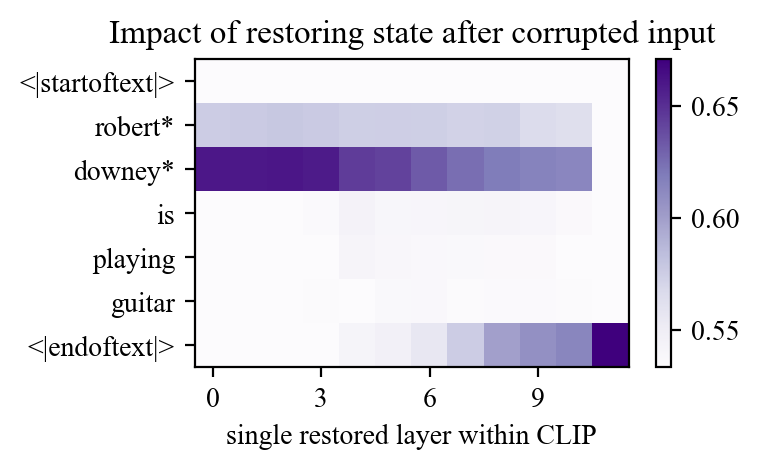

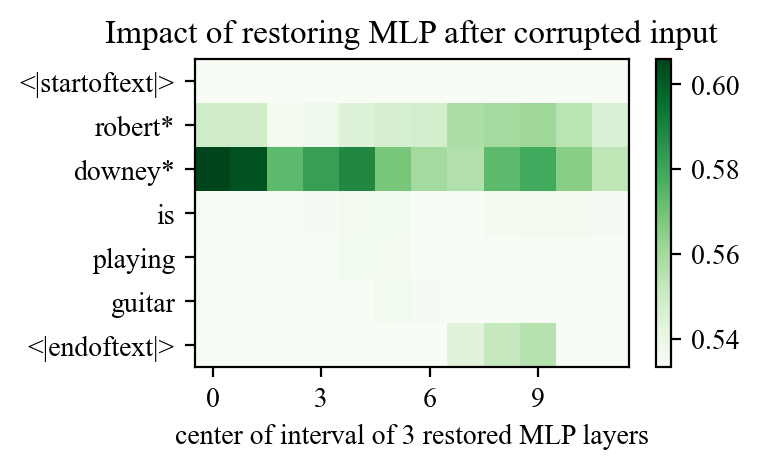

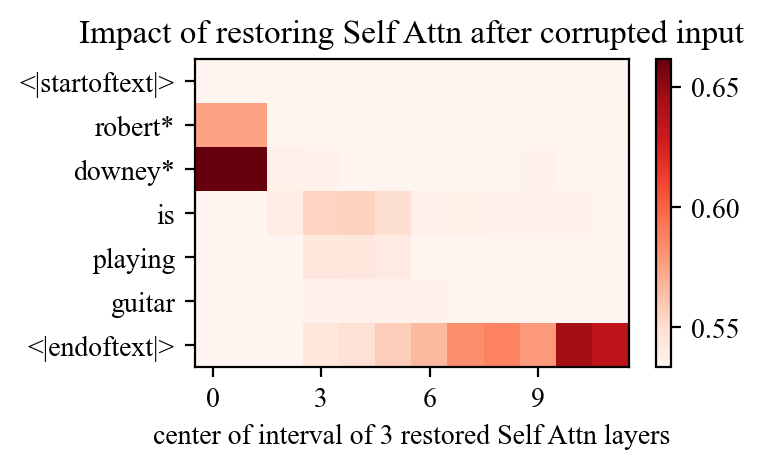

In [33]:
plot_all_flow(mt, sd_pipeline,"robert downey is playing guitar", subject='robert downey',noise=noise_level)